In [1]:
import os
import sys
import json
import traceback
from math import sqrt
import calendar
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
import xgboost
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Append the path of the utils directory.
sys.path.append("../util")

In [3]:
from date import is_leap_year

Config

In [4]:
DATASET_NAME = 'dehiwala_mc_2012-2018'

DAILY_WASTE_DATA_FILE_PATH = '../dataset/{}.csv'.format(DATASET_NAME)
RESULT_OUTPUT_DIR = '../../tmp/{}'.format(DATASET_NAME)
PREPROCESSING_CACHE_DIR_PATH = '{}/preprocessing_cache'.format(RESULT_OUTPUT_DIR)
DAILY_WASTE_OUTPUT_DATA_FILE_PATH = '{}/imputed_data.csv'.format(RESULT_OUTPUT_DIR)

In [5]:
if not os.path.exists(RESULT_OUTPUT_DIR):
    os.makedirs(RESULT_OUTPUT_DIR)

In [6]:
if not os.path.exists(PREPROCESSING_CACHE_DIR_PATH):
    os.makedirs(PREPROCESSING_CACHE_DIR_PATH)

Import datasets. 

In [7]:
df = pd.read_csv(DAILY_WASTE_DATA_FILE_PATH)

Find the categories under `waste_type`.

In [8]:
waste_type_list = list(df['waste_type'].unique())

Preprocess datasets. 

In [9]:
# Get the year.
df['year'] = pd.DatetimeIndex(df['ticket_date']).year

# Get the month.
df['month'] = pd.DatetimeIndex(df['ticket_date']).month

Filter the `ticket_date` and `net_weight_kg` columns.

In [10]:
df = df[['ticket_date', 'net_weight_kg']].groupby(['ticket_date']).agg('sum').reset_index()

Convert `ticket_date` to UTC.

In [11]:
df['ticket_date'] = pd.to_datetime(df['ticket_date'], utc=True)

Extract 2012 to 2015

In [12]:
df = df.loc[~(df['ticket_date'].dt.year > 2015)]
df = df.reset_index(drop=True)

Get dates between `2012-01-01` and `2015-12-31`.

In [13]:
date_range_df = pd.date_range(start="2012-01-01", end="2015-12-31").to_frame(index=False, name='ticket_date') 
date_range_df['ticket_date'] = pd.to_datetime(date_range_df['ticket_date'], utc=True)

Add the complete date range to the `df`.

In [14]:
df = pd.merge(left=date_range_df, right=df, how='left', left_on='ticket_date', right_on='ticket_date')

Info

In [15]:
missing_value_count = df["net_weight_kg"].isna().sum()
print(f'# available values: {df["net_weight_kg"].count()}')
print(f'# missing values: {missing_value_count}')

# available values: 1433
# missing values: 28


Remove outliers

In [16]:
# df['net_weight_kg'] = df['net_weight_kg'].interpolate(method='linear', limit_direction='both')
df = df.fillna(-200000)

In [17]:
df = df.set_index('ticket_date')

In [18]:
from adtk.data import validate_series
df = validate_series(df)
display(df)

,net_weight_kg
ticket_date,
2012-01-01 00:00:00+00:00,82270.0
2012-01-02 00:00:00+00:00,123010.0
2012-01-03 00:00:00+00:00,128330.0
2012-01-04 00:00:00+00:00,79430.0
2012-01-05 00:00:00+00:00,121320.0
...,...
2015-12-27 00:00:00+00:00,115540.0
2015-12-28 00:00:00+00:00,171530.0
2015-12-29 00:00:00+00:00,183330.0


[<AxesSubplot:>]

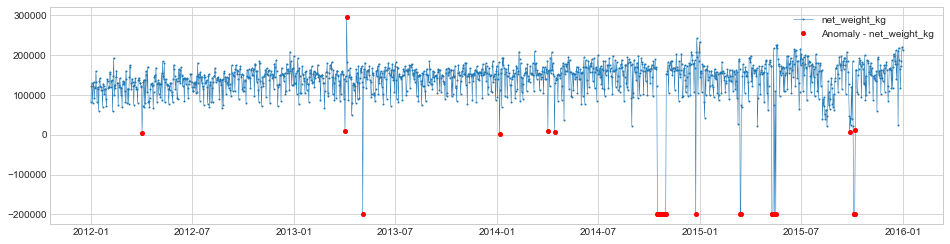

In [19]:
from adtk.detector import SeasonalAD
from adtk.visualization import plot
seasonal_ad = SeasonalAD()
anomalies = seasonal_ad.fit_detect(df)
plot(df, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [20]:
anomalies_mask = np.array(anomalies.reset_index()['net_weight_kg'].tolist())

In [21]:
print(f'# outliers: {anomalies_mask.sum() - missing_value_count}')

# outliers: 8


In [22]:
df['net_weight_kg'] = df['net_weight_kg'].iloc[~anomalies_mask]

In [23]:
df = df.reset_index()

Visualize the waste data.

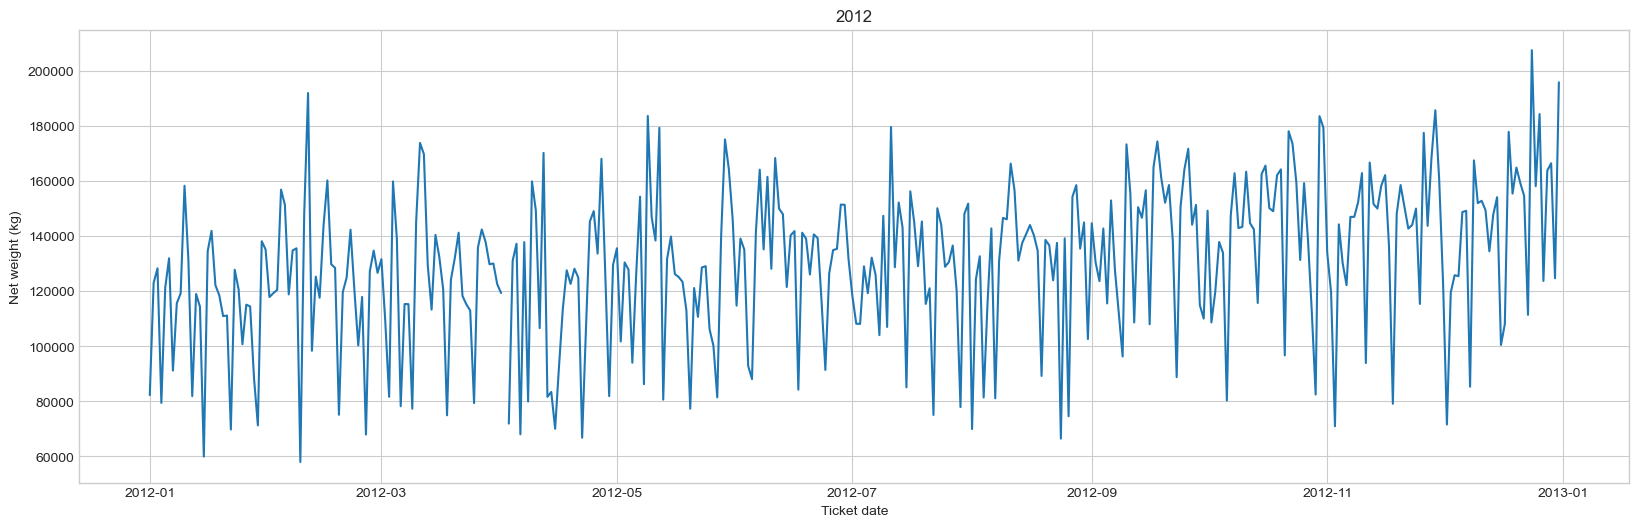

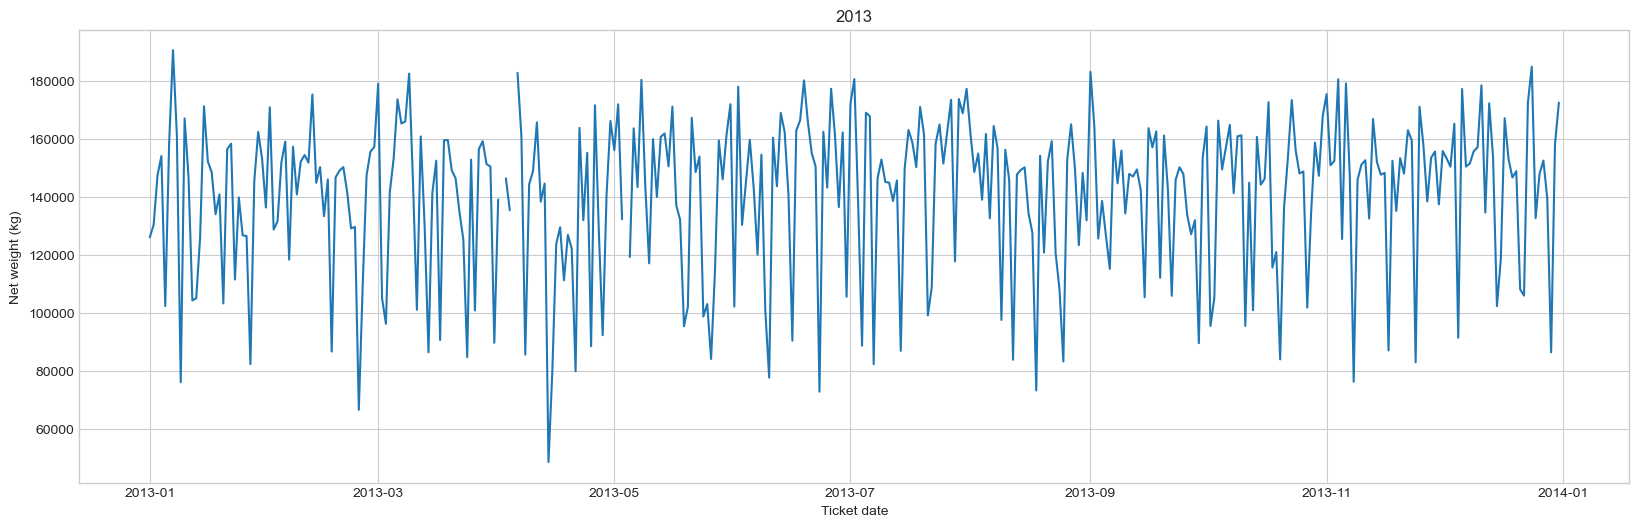

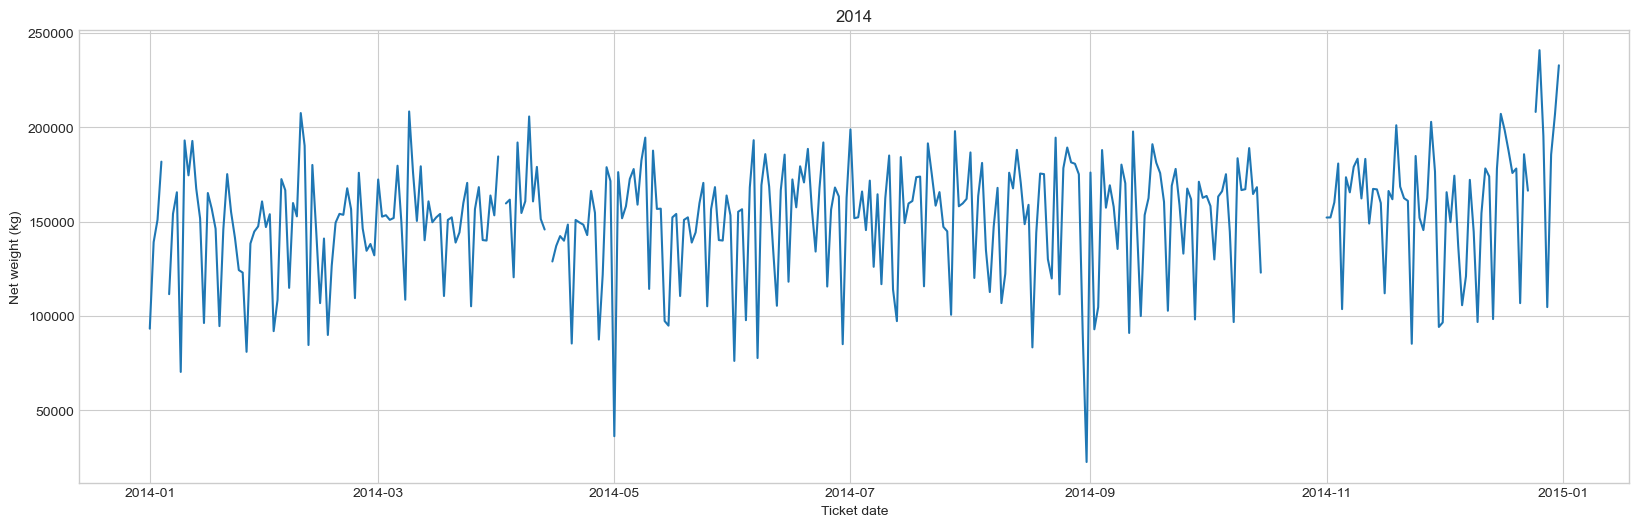

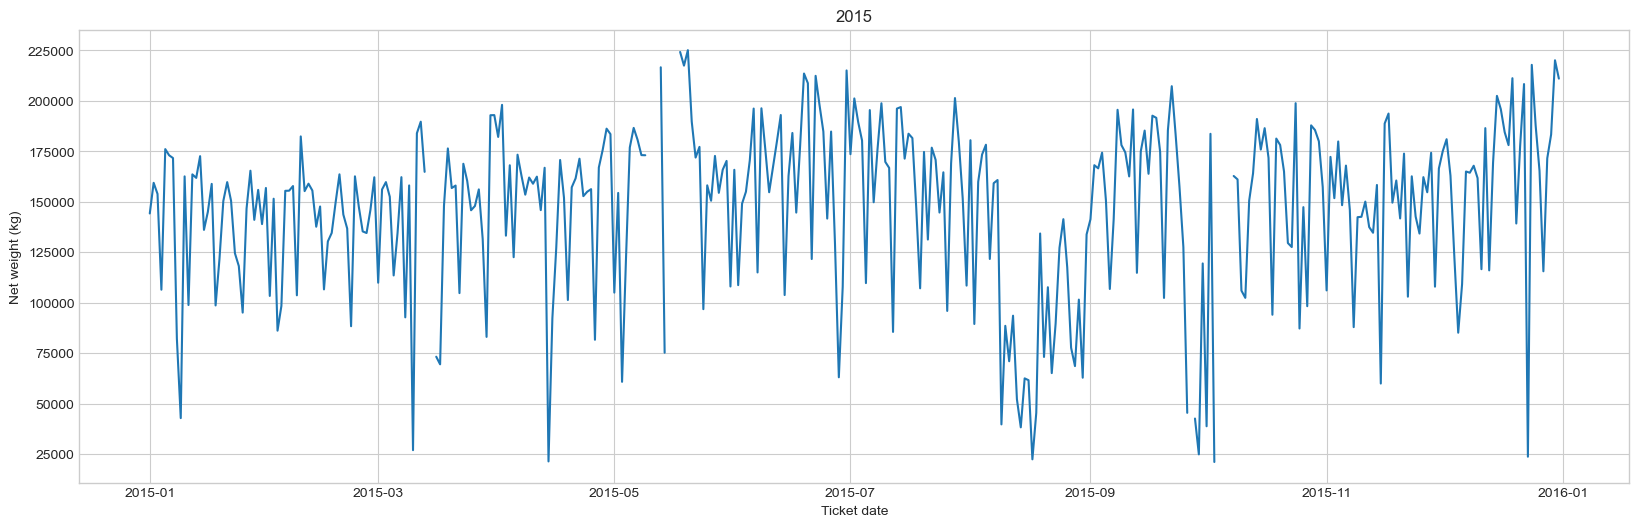

In [24]:
for year in range(2012, 2016):
    x = df[df['ticket_date'].dt.year == year]['ticket_date'].tolist()
    y = df[df['ticket_date'].dt.year == year]['net_weight_kg'].tolist()

    plt.rcParams['figure.dpi'] = 100
    plt.rcParams["figure.figsize"] = (20, 6)

    plt.plot(x, y)
    plt.title('{}'.format(year))
    plt.xlabel('Ticket date')
    plt.ylabel('Net weight (kg)')
    plt.show()

Determine the best model

In [25]:
lag_count_list = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 35, 42, 49, 56, 30, 60, 90, 120, 150, 180, 360]
estimator_count_list = [10, 100, 1000]
max_depth_list = [3, 4, 5, 6, 7, 8, 9]
subsample_list = [0.5, 0.6, 0.7, 0.8, 0.9]
eta_list = [0.001, 0.01, 0.1, 0.2, 0.3]

def evaluate(lag_count, estimator_count, max_depth, subsample, eta):    
    df_temp = df.copy()

    # Create lag features
    for i in range(1, lag_count + 1):
        df_temp['net_weight_kg_lag_{}'.format(i)] = df_temp['net_weight_kg'].shift(i)

    df_temp = df_temp.dropna()

    del df_temp['ticket_date']

    # Split the dataset
    X = df_temp.drop(['net_weight_kg'], axis=1)
    y = df_temp['net_weight_kg'].tolist()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
    
    model = xgboost.XGBRegressor(
        n_estimators=estimator_count, 
        seed=0,
        max_depth=max_depth,
        subsample=subsample,
        eta=eta
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    try:
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        return rmse
    except:
        traceback.print_exc()
    
results = []
n_iter = len(lag_count_list) * len(estimator_count_list) * len(max_depth_list) * len(subsample_list) * len(eta_list)
with tqdm(total=n_iter) as pbar:
    for lag_count in lag_count_list:
        for estimator_count in estimator_count_list:
            for max_depth in max_depth_list:
                for subsample in subsample_list:
                    for eta in eta_list:
                        preprocess_file_name = 'lag-{}_est-{}_dpt-{}_subsmp-{}_eta-{}.json'.format(
                            lag_count,
                            estimator_count,
                            max_depth,
                            subsample,
                            eta
                        )

                        # Check if test results exists
                        if os.path.exists('{}/{}'.format(PREPROCESSING_CACHE_DIR_PATH, preprocess_file_name)):
                            pbar.update(1)
                            continue

                        try:
                            rmse = evaluate(lag_count, estimator_count, max_depth, subsample, eta)
                        except:
                            pass

                        summary = {
                            'rmse': rmse,
                            'lag_count': lag_count,
                            'estimator_count': estimator_count,
                            'max_depth': max_depth,
                            'subsample': subsample,
                            'eta': eta
                        }
                        with open('{}/{}'.format(PREPROCESSING_CACHE_DIR_PATH, preprocess_file_name), 'w') as f:
                            json.dump(summary, f)            
                        
                        # Update progress bar.
                        pbar.update(1)

  0%|          | 0/11025 [00:00<?, ?it/s]

In [26]:
best_model_list = []
for lag_count in [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 35, 42, 49, 56, 30, 60, 90, 120, 150, 180, 360]:
    temp_results = []
    for dir_name in os.listdir(PREPROCESSING_CACHE_DIR_PATH):
        dir_path = os.path.abspath(dir_name)
        if dir_name.startswith('lag-{}_'.format(lag_count)):
            try:
                with open('{}/{}'.format(PREPROCESSING_CACHE_DIR_PATH, dir_name)) as f:
                    summary = json.load(f)
                    temp_results.append((summary['rmse'], summary))
            except:
                pass
    
    temp_results = sorted(temp_results, key=lambda x: x[0])
    best_model_list.append(temp_results[0])

In [27]:
# optimum_lag_model_params = sorted(best_model_list, key=lambda x: x[0])[0][1]
# display(optimum_lag_model_params)

# Choose the second best model because lag-360 is not good for this dataset
optimum_lag_model_params = sorted(best_model_list, key=lambda x: x[0])[1][1]
display(optimum_lag_model_params)

{'rmse': 20713.04025985531,
 'lag_count': 120,
 'estimator_count': 1000,
 'max_depth': 8,
 'subsample': 0.9,
 'eta': 0.1}

In [28]:
first_null_index = df[df.isnull().any(axis=1)].index[0]
modified_best_model_list = [model for model in best_model_list if model[1]['lag_count'] < first_null_index]
minimum_lag_model_params = sorted(modified_best_model_list, key=lambda x: x[0])[0][1]
display(minimum_lag_model_params)

{'rmse': 23492.06335522047,
 'lag_count': 90,
 'estimator_count': 1000,
 'max_depth': 7,
 'subsample': 0.6,
 'eta': 0.01}

Impute missing data

In [29]:
def evaluate_forecast(actual, predicted, plot_title=None):
    rmse = None
    mae = None
    mape = None

    try:
        rmse = sqrt(mean_squared_error(actual, predicted))
        print('RMSE: {}'.format(rmse))
    except:
        print(actual)
        print(predicted)
        traceback.print_exc()

    try:
        mae = mean_absolute_error(actual, predicted)
        print('MAE: {}'.format(mae))
    except:
        traceback.print_exc()

    try:
        mape = mean_absolute_percentage_error(actual, predicted)
        print('MAPE: {}'.format(mape))
    except:
        traceback.print_exc()

    plt.rcParams['figure.dpi'] = 100
    plt.rcParams["figure.figsize"] = (20, 6)
    plt.plot(actual)
    plt.plot(predicted)
    if not plot_title: plt.title(plot_title)
    plt.show()

    return rmse, mae, mape

Model

Optimum lag model

C:\Users\oshan\anaconda3\envs\waste-prediction-project\lib\site-packages\ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


RMSE: 20713.04025985531
MAE: 16023.233146067416
MAPE: 0.13117977288523375


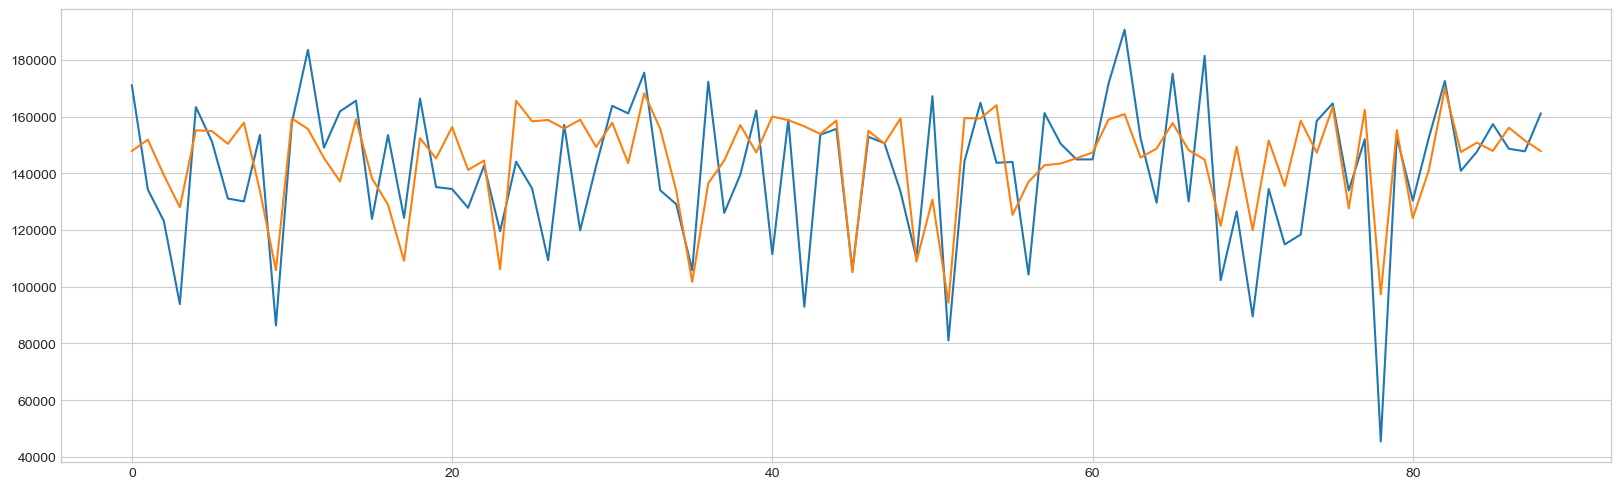

(20713.04025985531, 16023.233146067416, 0.13117977288523375)

In [30]:
df_temp = df.copy()

# Create lag features
for i in range(1, optimum_lag_model_params['lag_count'] + 1):
    df_temp['net_weight_kg_lag_{}'.format(i)] = df_temp['net_weight_kg'].shift(i)

df_temp = df_temp.dropna()
    
del df_temp['ticket_date']

# Split the dataset
X = df_temp.drop(['net_weight_kg'], axis=1)
y = df_temp['net_weight_kg'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

model_optimum = xgboost.XGBRegressor(
    n_estimators=optimum_lag_model_params['estimator_count'], 
    seed=0,
    max_depth=optimum_lag_model_params['max_depth'],
    subsample=optimum_lag_model_params['subsample'],
    eta=optimum_lag_model_params['eta']
)
model_optimum.fit(X_train, y_train)

y_pred = model_optimum.predict(X_test)

evaluate_forecast(y_test, y_pred)

Minimum lag model

RMSE: 23492.06335522047
MAE: 18728.173245614034
MAPE: 0.15052441838086086


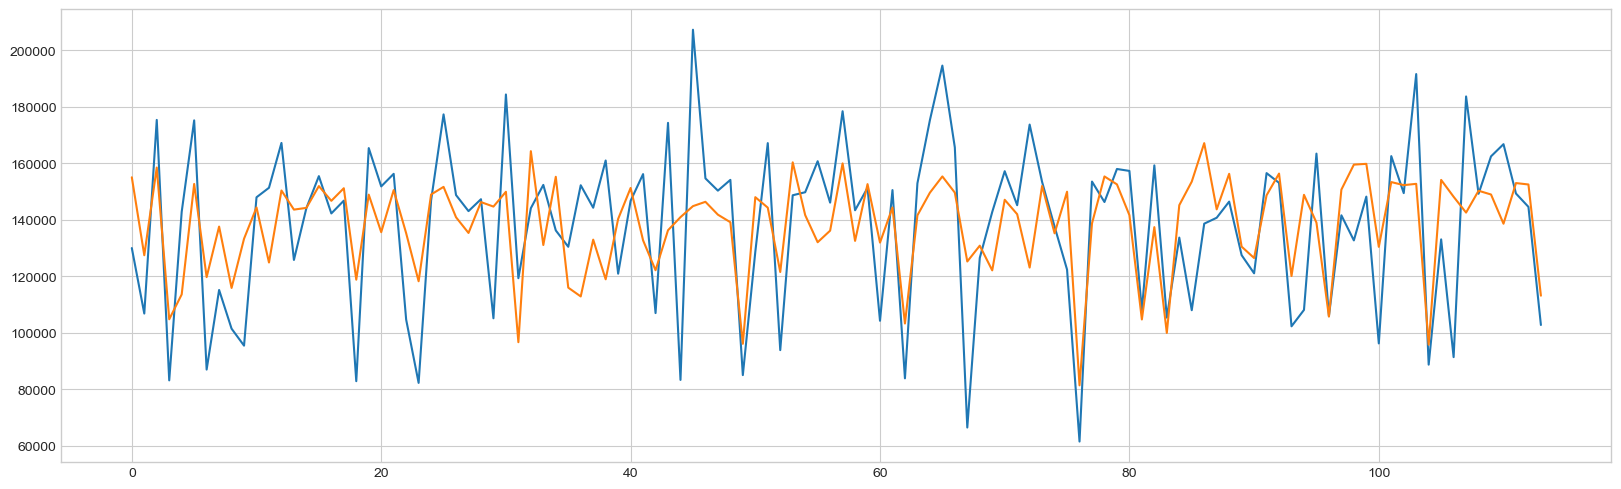

(23492.06335522047, 18728.173245614034, 0.15052441838086086)

In [31]:
df_temp = df.copy()

# Create lag features
for i in range(1, minimum_lag_model_params['lag_count'] + 1):
    df_temp['net_weight_kg_lag_{}'.format(i)] = df_temp['net_weight_kg'].shift(i)

df_temp = df_temp.dropna()
    
del df_temp['ticket_date']

# Split the dataset
X = df_temp.drop(['net_weight_kg'], axis=1)
y = df_temp['net_weight_kg'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

model_minimum = xgboost.XGBRegressor(
    n_estimators=minimum_lag_model_params['estimator_count'], 
    seed=0,
    max_depth=minimum_lag_model_params['max_depth'],
    subsample=minimum_lag_model_params['subsample'],
    eta=minimum_lag_model_params['eta']
)
model_minimum.fit(X_train, y_train)

y_pred = model_minimum.predict(X_test)

evaluate_forecast(y_test, y_pred)

In [32]:
# Impute data
df['predicted_net_weight_kg'] = np.nan
for index, row in df.iterrows():
    ticket_date = row['ticket_date']
    net_weight_kg = row['net_weight_kg']

    if not pd.notnull(row['net_weight_kg']):
        if index > optimum_lag_model_params['lag_count']:
            previous_values = df[index - optimum_lag_model_params['lag_count']:index]['net_weight_kg'].tolist()[::-1]
            column_list = []
            for i in range(1, optimum_lag_model_params['lag_count'] + 1):
                column_list.append('net_weight_kg_lag_{}'.format(i))

            previous_df = pd.DataFrame([previous_values], columns=column_list)
            current_value_pred = model_optimum.predict(previous_df)
        else:
            previous_values = df[index - minimum_lag_model_params['lag_count']:index]['net_weight_kg'].tolist()[::-1]
            column_list = []
            for i in range(1, minimum_lag_model_params['lag_count'] + 1):
                column_list.append('net_weight_kg_lag_{}'.format(i))

            previous_df = pd.DataFrame([previous_values], columns=column_list)
            current_value_pred = model_minimum.predict(previous_df)

        df.at[index,'net_weight_kg'] = current_value_pred
        df.at[index,'predicted_net_weight_kg'] = current_value_pred

In [33]:
print(f'# imputed values: {df["predicted_net_weight_kg"].count()}')
print(f'Percentage of imputed values: {df["predicted_net_weight_kg"].count() / df["predicted_net_weight_kg"].isna().sum() * 100.0}')
print(f'Mean daily weight: {df["predicted_net_weight_kg"].mean()}')
print(f'SD daily weight: {df["predicted_net_weight_kg"].std()}')

# imputed values: 36
Percentage of imputed values: 2.526315789473684
Mean daily weight: 140640.93500434028
SD daily weight: 30227.452245550237


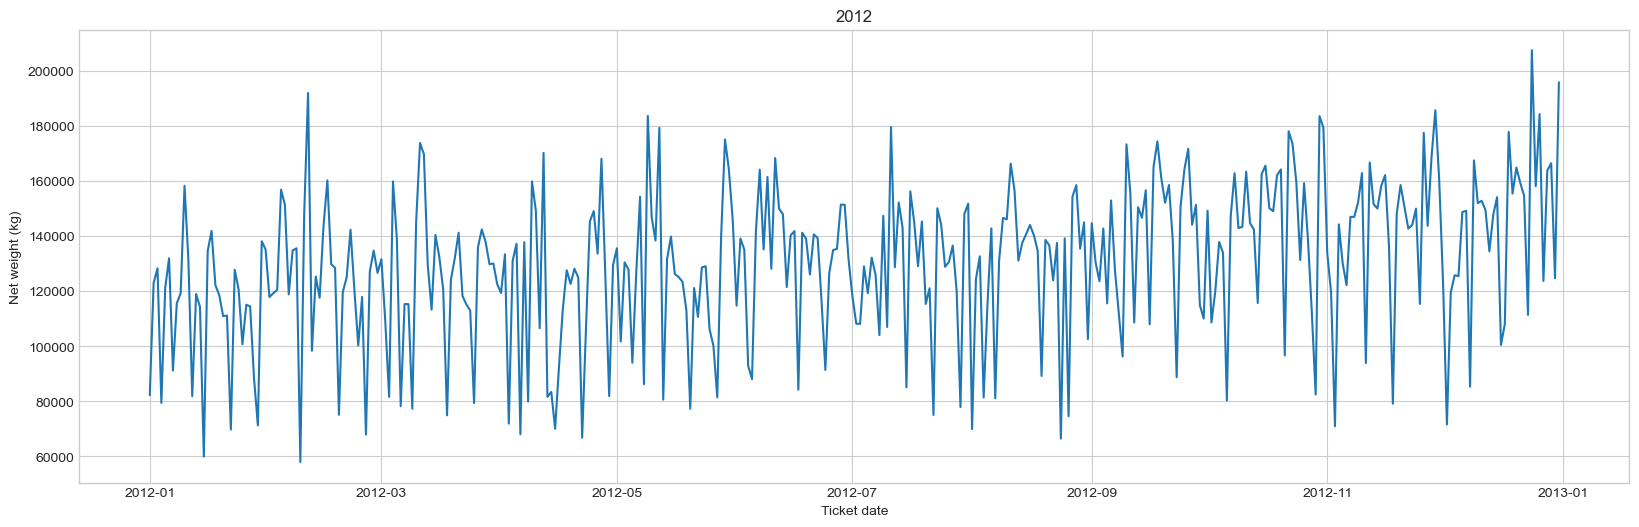

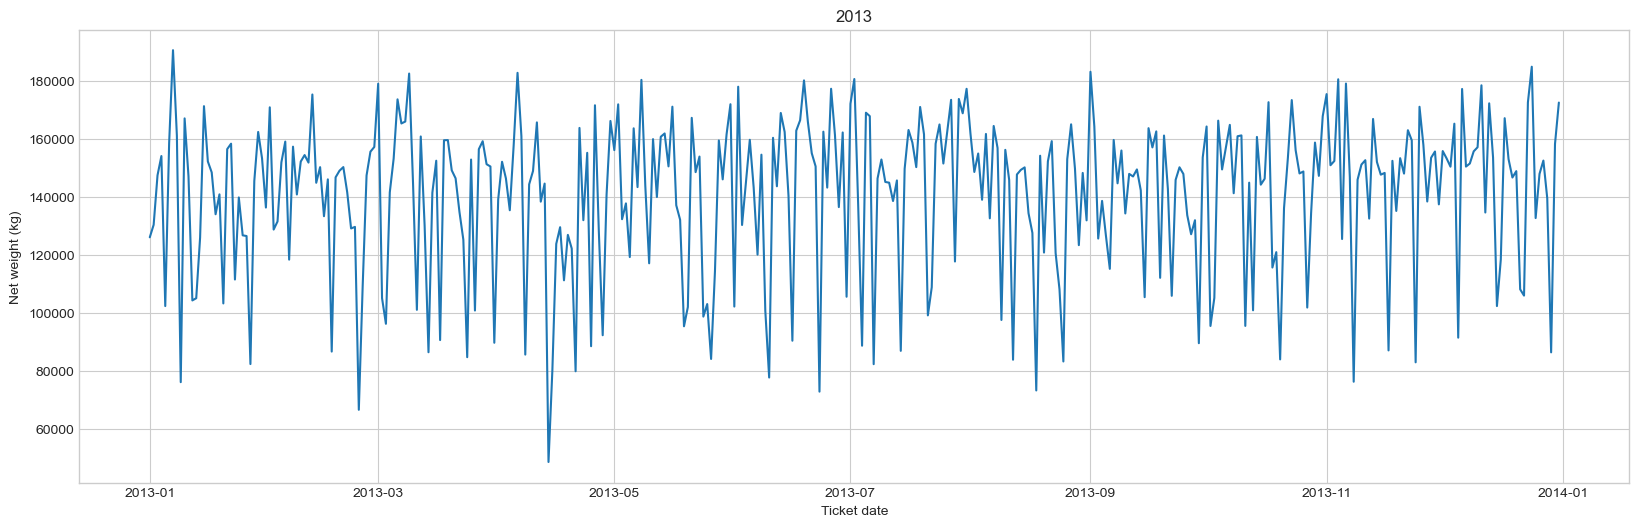

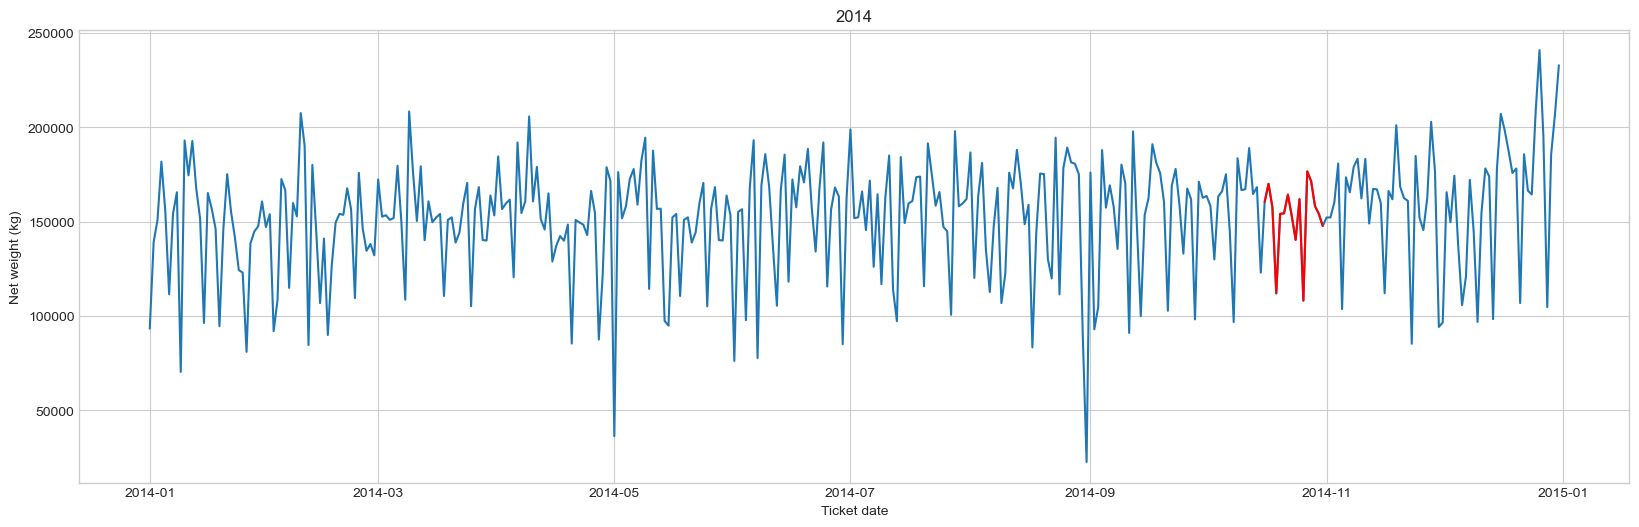

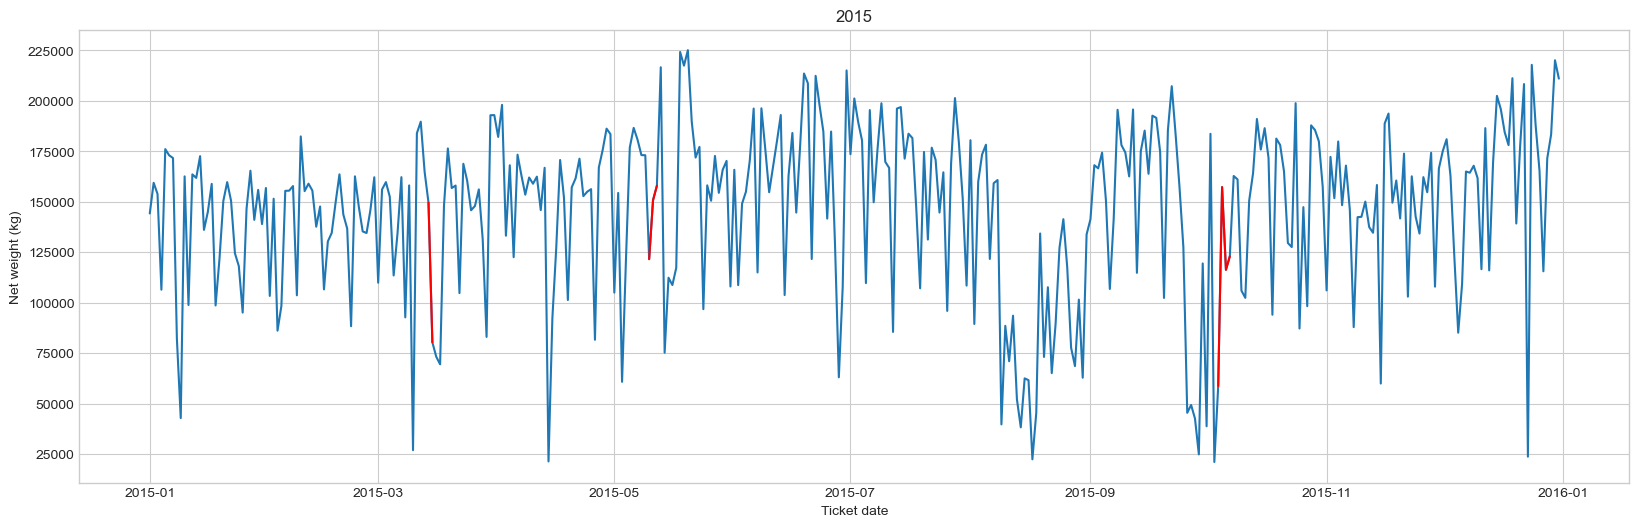

In [34]:
for year in range(2012, 2016):
    x = df[df['ticket_date'].dt.year == year]['ticket_date'].tolist()
    y = df[df['ticket_date'].dt.year == year]['net_weight_kg'].tolist()
    y_pred = df[df['ticket_date'].dt.year == year]['predicted_net_weight_kg'].tolist()

    plt.rcParams['figure.dpi'] = 100
    plt.rcParams["figure.figsize"] = (20, 6)

    plt.plot(x, y)
    plt.plot(x, y_pred, color='red')
    plt.title('{}'.format(year))
    plt.xlabel('Ticket date')
    plt.ylabel('Net weight (kg)')
    plt.show()

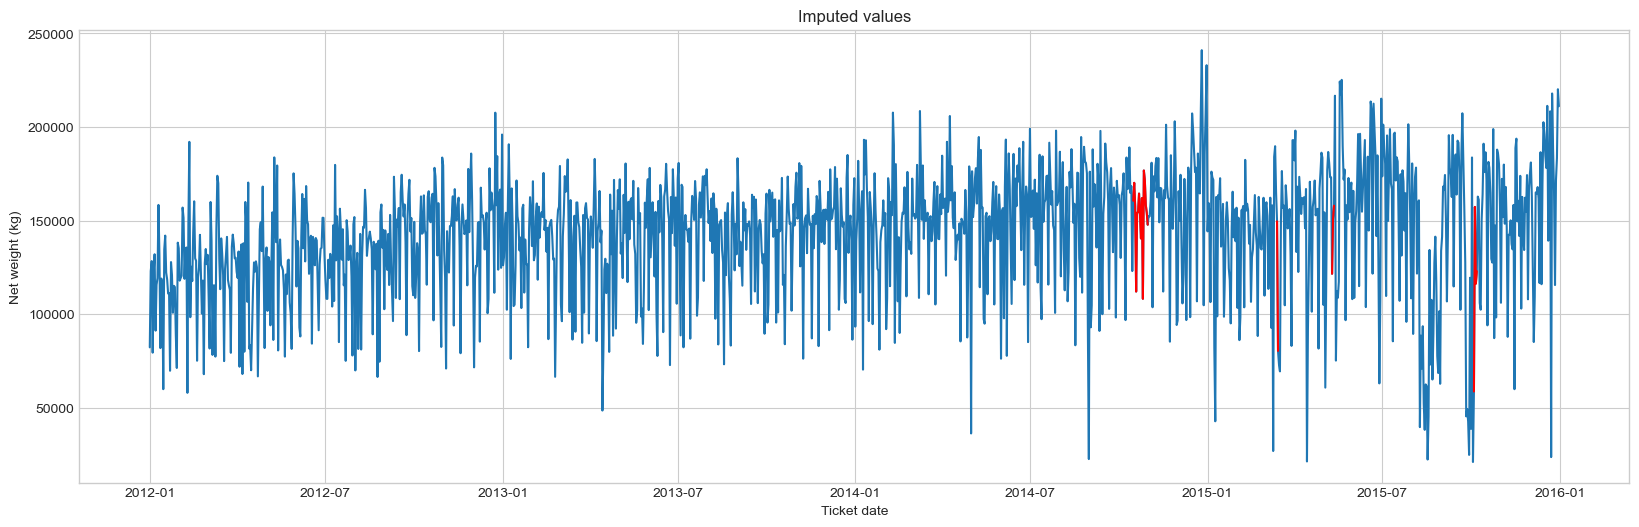

In [35]:
x = df['ticket_date'].tolist()
y = df['net_weight_kg'].tolist()
y_pred = df['predicted_net_weight_kg'].tolist()

plt.plot(x, y)
plt.plot(x, y_pred, color='red')
plt.title('Imputed values')
plt.xlabel('Ticket date')
plt.ylabel('Net weight (kg)')
plt.show()

In [36]:
del df['predicted_net_weight_kg']

In [37]:
df.to_csv(DAILY_WASTE_OUTPUT_DATA_FILE_PATH, index=False)

Trend

In [38]:
DEGREE_OF_TREND = 1

Trend start: 129404.01 kg
Trend end: 154990.84 kg


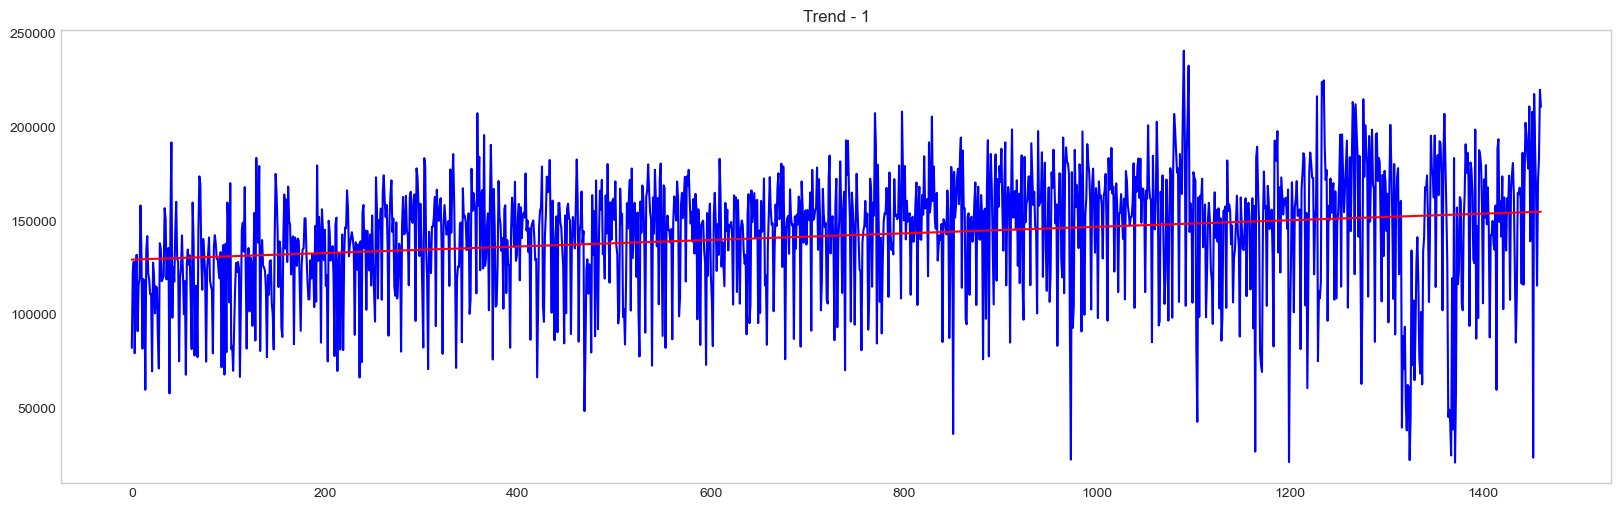

In [39]:
x = range(len(df))
y = df['net_weight_kg']
plt.plot(x, y, color='blue')

# For trends.
z = np.polyfit(x, y, DEGREE_OF_TREND)
p = np.poly1d(z)
y_trend = p(x)
plt.plot(x, y_trend, color='red')

print('Trend start: {:.2f} kg\nTrend end: {:.2f} kg'.format(y_trend[0], y_trend[-1]))

plt.title('Trend - {}'.format(DEGREE_OF_TREND))
plt.grid()
plt.show()

Seasonal plot

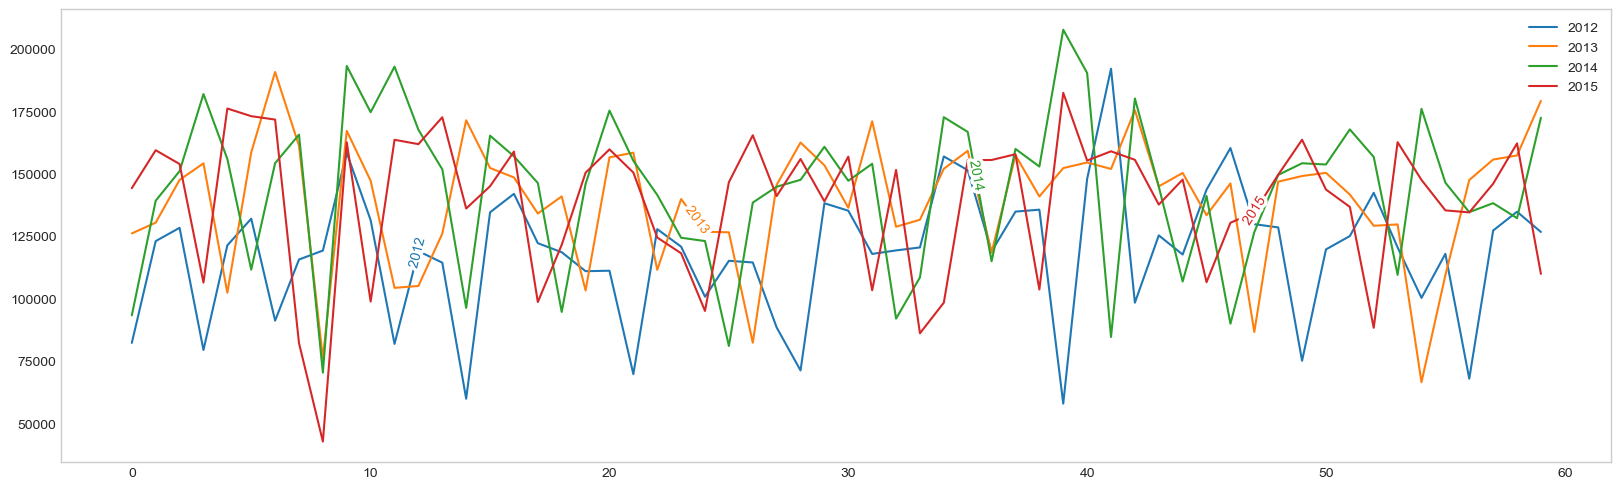

In [40]:
y = df['net_weight_kg']

hist = 0
for year in range(2012, 2016):
    if year != 2016:
        is_leap = is_leap_year(year)
        if is_leap:
            x = range(366)[:60]
            y_part = y[hist :hist + 366][:60]
            hist += 366
        else:
            x = range(365)[:60]
            y_part = y[hist:hist + 365][:60]
            hist += 365
        line_label = label='{}'.format(year)
        plt.plot(x, y_part, label=line_label)

labelLines(plt.gca().get_lines())
# plt.title('{} - {}'.format(main_group, sub_group))
# plt.xticks(x, x_ticks, rotation=70, ha='right')
plt.grid()
plt.legend()
plt.show()